# Tech Challenge - Fase 2
# Algoritmos Genéticos para Otimização de Alocação de Recursos

In [1]:
# Célula 1: Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import List, Tuple, Dict, Any
import time
from tqdm import tqdm
import copy

# Célula 2: Definição do problema

"""
# Problema de Alocação de Recursos em Projetos de TI

## Descrição do Problema
Uma empresa de tecnologia possui diversos projetos simultâneos e precisa alocar seus recursos humanos
(desenvolvedores) de forma otimizada. Cada desenvolvedor possui diferentes níveis de habilidade
em diversas competências (desenvolvimento back-end, front-end, banco de dados, DevOps, etc.).
Cada projeto requer diferentes níveis dessas competências.

## Objetivo
Encontrar a melhor alocação de desenvolvedores para os projetos, de modo a:
1. Maximizar a correspondência entre as habilidades dos desenvolvedores e as necessidades dos projetos
2. Minimizar o tempo ocioso dos desenvolvedores (subutilização)
3. Garantir que todos os projetos tenham as competências mínimas necessárias
4. Respeitar os limites de alocação de cada desenvolvedor (um desenvolvedor não pode ser alocado em mais projetos do que sua capacidade)

## Restrições
1. Cada desenvolvedor tem uma capacidade máxima de horas semanais (40h)
2. Cada projeto tem requisitos mínimos de horas por competência
3. Um desenvolvedor pode ser alocado parcialmente em múltiplos projetos
4. Alguns projetos têm prioridade maior que outros
"""

In [2]:
# Célula 3: Definição das estruturas de dados

# Definição de um desenvolvedor
class Desenvolvedor:
    def __init__(self, id: int, nome: str, habilidades: Dict[str, int], capacidade_horas: int = 40):
        """
        Inicializa um desenvolvedor.

        Args:
            id: Identificador único do desenvolvedor
            nome: Nome do desenvolvedor
            habilidades: Dicionário com as habilidades do desenvolvedor e seus níveis (1-10)
            capacidade_horas: Quantidade máxima de horas semanais disponíveis
        """
        self.id = id
        self.nome = nome
        self.habilidades = habilidades
        self.capacidade_horas = capacidade_horas
        self.horas_alocadas = 0

    def horas_disponiveis(self) -> int:
        """Retorna a quantidade de horas ainda disponíveis"""
        return self.capacidade_horas - self.horas_alocadas

    def __str__(self) -> str:
        return f"Dev {self.id}: {self.nome} - Habilidades: {self.habilidades} - Disponível: {self.horas_disponiveis()}h"


# Definição de um projeto
class Projeto:
    def __init__(self, id: int, nome: str, requisitos: Dict[str, int], prioridade: int, horas_minimas: Dict[str, int]):
        """
        Inicializa um projeto.

        Args:
            id: Identificador único do projeto
            nome: Nome do projeto
            requisitos: Dicionário com os requisitos de habilidades e seus níveis mínimos (1-10)
            prioridade: Nível de prioridade do projeto (1-10, sendo 10 o mais prioritário)
            horas_minimas: Dicionário com o mínimo de horas necessárias por competência
        """
        self.id = id
        self.nome = nome
        self.requisitos = requisitos
        self.prioridade = prioridade
        self.horas_minimas = horas_minimas
        self.alocacoes = {}  # Dict[id_desenvolvedor, Dict[competência, horas]]

    def horas_alocadas_por_competencia(self) -> Dict[str, int]:
        """Retorna o total de horas alocadas por competência"""
        result = {comp: 0 for comp in self.requisitos.keys()}
        for dev_id, alocacao in self.alocacoes.items():
            for comp, horas in alocacao.items():
                if comp in result:
                    result[comp] += horas
        return result

    def necessidades_nao_atendidas(self) -> Dict[str, int]:
        """Retorna as competências com horas insuficientes"""
        horas_alocadas = self.horas_alocadas_por_competencia()
        return {comp: max(0, self.horas_minimas[comp] - horas_alocadas.get(comp, 0))
                for comp in self.horas_minimas}

    def esta_completo(self) -> bool:
        """Verifica se todas as necessidades do projeto estão atendidas"""
        return sum(self.necessidades_nao_atendidas().values()) == 0

    def __str__(self) -> str:
        necessidades = self.necessidades_nao_atendidas()
        status = "Completo" if self.esta_completo() else f"Pendente: {necessidades}"
        return f"Projeto {self.id}: {self.nome} (Prioridade: {self.prioridade}) - {status}"

In [3]:
# Célula 4: Criação dos dados de teste

# Definição das competências
competencias = ['Backend', 'Frontend', 'Database', 'DevOps', 'Mobile', 'UI/UX', 'QA']

# Criação dos desenvolvedores
def criar_desenvolvedores(n: int = 20) -> List[Desenvolvedor]:
    desenvolvedores = []
    nomes = [f"Desenvolvedor_{i}" for i in range(1, n+1)]

    for i in range(n):
        # Gera habilidades aleatórias entre 1-10 para cada competência
        habilidades = {comp: random.randint(1, 10) for comp in competencias}

        # Alguns desenvolvedores são especialistas em certas áreas
        area_especialista = random.choice(competencias)
        habilidades[area_especialista] = min(10, habilidades[area_especialista] + random.randint(1, 3))

        # Alguns desenvolvedores têm capacidade reduzida (trabalho parcial)
        capacidade = 40 if random.random() > 0.2 else random.choice([20, 30])

        dev = Desenvolvedor(i, nomes[i], habilidades, capacidade)
        desenvolvedores.append(dev)

    return desenvolvedores

# Criação dos projetos
def criar_projetos(n: int = 8) -> List[Projeto]:
    projetos = []
    nomes_projetos = [
        "Portal de E-commerce", "Sistema de RH", "App Móvel", "Dashboard Analítico",
        "Migração para Nuvem", "Redesign de UX", "Sistema de Pagamentos", "Plataforma de BI",
        "CRM Corporativo", "Sistema de Gestão de Frotas"
    ]

    for i in range(n):
        # Seleciona um nome da lista ou gera um se necessário
        nome = nomes_projetos[i] if i < len(nomes_projetos) else f"Projeto_{i}"

        # Cada projeto precisa de 3-6 competências específicas
        num_competencias = random.randint(3, min(6, len(competencias)))
        comps_projeto = random.sample(competencias, num_competencias)

        # Requisitos mínimos de habilidade para cada competência (3-8)
        requisitos = {comp: random.randint(3, 8) for comp in comps_projeto}

        # Horas mínimas necessárias para cada competência (10-40h)
        horas_minimas = {comp: random.randint(10, 40) for comp in comps_projeto}

        # Prioridade do projeto (1-10)
        prioridade = random.randint(1, 10)

        projeto = Projeto(i, nome, requisitos, prioridade, horas_minimas)
        projetos.append(projeto)

    return projetos

# Gera os dados
desenvolvedores = criar_desenvolvedores(20)
projetos = criar_projetos(8)

# Exibe resumo dos dados gerados
print(f"Dados gerados: {len(desenvolvedores)} desenvolvedores e {len(projetos)} projetos")
print("\nAmostra de desenvolvedores:")
for dev in desenvolvedores[:3]:
    print(dev)

print("\nAmostra de projetos:")
for proj in projetos[:3]:
    print(proj)
    print(f"  Requisitos: {proj.requisitos}")
    print(f"  Horas mínimas: {proj.horas_minimas}")
    print()

Dados gerados: 20 desenvolvedores e 8 projetos

Amostra de desenvolvedores:
Dev 0: Desenvolvedor_1 - Habilidades: {'Backend': 6, 'Frontend': 10, 'Database': 4, 'DevOps': 10, 'Mobile': 8, 'UI/UX': 4, 'QA': 3} - Disponível: 40h
Dev 1: Desenvolvedor_2 - Habilidades: {'Backend': 2, 'Frontend': 8, 'Database': 7, 'DevOps': 5, 'Mobile': 10, 'UI/UX': 10, 'QA': 9} - Disponível: 40h
Dev 2: Desenvolvedor_3 - Habilidades: {'Backend': 5, 'Frontend': 5, 'Database': 3, 'DevOps': 3, 'Mobile': 8, 'UI/UX': 5, 'QA': 2} - Disponível: 40h

Amostra de projetos:
Projeto 0: Portal de E-commerce (Prioridade: 6) - Pendente: {'UI/UX': 38, 'DevOps': 34, 'Backend': 25}
  Requisitos: {'UI/UX': 4, 'DevOps': 4, 'Backend': 6}
  Horas mínimas: {'UI/UX': 38, 'DevOps': 34, 'Backend': 25}

Projeto 1: Sistema de RH (Prioridade: 6) - Pendente: {'Mobile': 13, 'Backend': 14, 'DevOps': 30}
  Requisitos: {'Mobile': 6, 'Backend': 6, 'DevOps': 5}
  Horas mínimas: {'Mobile': 13, 'Backend': 14, 'DevOps': 30}

Projeto 2: App Móvel (

In [4]:
# Célula 5: Definição da representação dos indivíduos
"""
Para este problema, um indivíduo (possível solução) será representado como uma matriz de alocação,
onde cada posição (i,j,k) indica quanto tempo o desenvolvedor i dedica ao projeto j na competência k.

Optamos por essa representação complexa porque:
1. Permite alocações parciais (um desenvolvedor pode trabalhar em vários projetos)
2. Permite alocações específicas por competência (um desenvolvedor pode contribuir em diferentes áreas)
3. Facilita o cálculo da função de fitness e a validação das restrições
"""

class Individuo:
    def __init__(self, desenvolvedores: List[Desenvolvedor], projetos: List[Projeto]):
        """
        Inicializa um indivíduo (solução candidata).

        Args:
            desenvolvedores: Lista de desenvolvedores disponíveis
            projetos: Lista de projetos a serem alocados
        """
        self.desenvolvedores = desenvolvedores
        self.projetos = projetos
        self.fitness = 0

        # Inicializa a matriz de alocação com zeros
        # alocacao[dev_id][proj_id][competencia] = horas
        self.alocacao = {}
        for dev in desenvolvedores:
            self.alocacao[dev.id] = {}
            for proj in projetos:
                self.alocacao[dev.id][proj.id] = {}
                for comp in competencias:
                    self.alocacao[dev.id][proj.id][comp] = 0

        # Inicializa com uma alocação aleatória
        self.gerar_alocacao_aleatoria()

    def gerar_alocacao_aleatoria(self):
        """Gera uma alocação aleatória inicial respeitando as capacidades"""
        # Reseta alocações
        for dev in self.desenvolvedores:
            dev.horas_alocadas = 0

        for proj in self.projetos:
            proj.alocacoes = {}

        # Lista de projetos ordenados por prioridade (do mais prioritário para o menos)
        projetos_ordenados = sorted(self.projetos, key=lambda p: p.prioridade, reverse=True)

        for projeto in projetos_ordenados:
            # Para cada competência necessária no projeto
            for comp, horas_necessarias in projeto.horas_minimas.items():
                horas_alocadas = 0

                # Filtra desenvolvedores com essa competência, ordenados por nível
                devs_compativeis = sorted(
                    [dev for dev in self.desenvolvedores if comp in dev.habilidades and dev.horas_disponiveis() > 0],
                    key=lambda d: d.habilidades[comp],
                    reverse=True
                )

                # Tenta alocar as horas necessárias
                while horas_alocadas < horas_necessarias and devs_compativeis:
                    for dev in devs_compativeis[:]:
                        # Determina quantas horas alocar (entre 1 e o mínimo entre o disponível e o necessário)
                        horas_disponiveis = dev.horas_disponiveis()
                        if horas_disponiveis <= 0:
                            devs_compativeis.remove(dev)
                            continue

                        horas_restantes = horas_necessarias - horas_alocadas
                        horas_a_alocar = min(
                            random.randint(1, max(1, min(10, horas_disponiveis))),
                            horas_disponiveis,
                            horas_restantes
                        )

                        if horas_a_alocar > 0:
                            # Atualiza a alocação
                            self.alocacao[dev.id][projeto.id][comp] = horas_a_alocar

                            # Atualiza as horas alocadas do desenvolvedor
                            dev.horas_alocadas += horas_a_alocar

                            # Atualiza as alocações do projeto
                            if dev.id not in projeto.alocacoes:
                                projeto.alocacoes[dev.id] = {}
                            projeto.alocacoes[dev.id][comp] = horas_a_alocar

                            horas_alocadas += horas_a_alocar

                        if horas_alocadas >= horas_necessarias:
                            break

                    # Se não conseguiu alocar tudo e não tem mais desenvolvedores, interrompe
                    if horas_alocadas < horas_necessarias and not devs_compativeis:
                        break

        # Atualiza o fitness
        self.calcular_fitness()

    def calcular_fitness(self):
        """Calcula o valor de fitness do indivíduo"""
        # Componentes do fitness
        match_habilidade = 0  # Correspondência entre habilidades e requisitos
        horas_nao_atendidas = 0  # Horas necessárias não atendidas
        utilizacao_recursos = 0  # Percentual de utilização dos recursos humanos
        balanco_carga = 0  # Quão bem distribuída está a carga de trabalho

        # 1. Correspondência entre habilidades e requisitos
        for dev_id, proj_dict in self.alocacao.items():
            dev = next(d for d in self.desenvolvedores if d.id == dev_id)

            for proj_id, comp_dict in proj_dict.items():
                projeto = next(p for p in self.projetos if p.id == proj_id)

                for comp, horas in comp_dict.items():
                    if horas > 0 and comp in projeto.requisitos and comp in dev.habilidades:
                        # Calcula o quanto a habilidade do desenvolvedor atende o requisito
                        req_nivel = projeto.requisitos[comp]
                        dev_nivel = dev.habilidades[comp]

                        # A diferença entre o nível do desenvolvedor e o requisito (normalizado para 0-1)
                        # Um valor positivo significa que o dev excede o requisito, negativo significa déficit
                        diff = (dev_nivel - req_nivel) / 10.0

                        # Penaliza mais diferenças negativas (dev abaixo do requisito)
                        if diff < 0:
                            pontos = 1 + diff  # Entre 0-1
                        else:
                            pontos = 1 + (diff * 0.5)  # Bonificação menor para excesso de qualificação

                        match_habilidade += pontos * horas

        # 2. Horas não atendidas (necessidades)
        for projeto in self.projetos:
            necessidades = projeto.necessidades_nao_atendidas()
            horas_faltantes = sum(necessidades.values())
            horas_nao_atendidas += horas_faltantes * (projeto.prioridade / 5)  # Projetos prioritários pesam mais

        # 3. Utilização de recursos (quão bem alocados estão os desenvolvedores)
        total_capacidade = sum(dev.capacidade_horas for dev in self.desenvolvedores)
        total_alocado = sum(dev.horas_alocadas for dev in self.desenvolvedores)
        if total_capacidade > 0:
            utilizacao_recursos = total_alocado / total_capacidade

        # 4. Balanço de carga (desvio padrão da utilização percentual)
        utilizacoes = [dev.horas_alocadas / dev.capacidade_horas for dev in self.desenvolvedores]
        if utilizacoes:
            balanco_carga = 1 - np.std(utilizacoes)  # Quanto menor o desvio padrão, melhor

        # Cálculo do fitness final (pesos diferentes para cada componente)
        fitness = (
            match_habilidade * 0.4 +  # Correspondência habilidade-requisito (quanto maior, melhor)
            -horas_nao_atendidas * 8.0 +  # Necessidades não atendidas (quanto menor, melhor)
            utilizacao_recursos * 300.0 +  # Utilização de recursos (quanto maior, melhor)
            balanco_carga * 200.0  # Balanço de carga (quanto maior, melhor)
        )

        self.fitness = fitness
        return fitness

    def copy(self):
        """Cria uma cópia do indivíduo"""
        novo = Individuo(self.desenvolvedores, self.projetos)
        novo.alocacao = copy.deepcopy(self.alocacao)
        novo.fitness = self.fitness

        # Reseta as alocações dos projetos
        for proj in novo.projetos:
            proj.alocacoes = {}

        # Reseta as horas alocadas dos desenvolvedores
        for dev in novo.desenvolvedores:
            dev.horas_alocadas = 0

        # Recalcula as alocações conforme a matriz
        for dev_id, proj_dict in novo.alocacao.items():
            dev = next(d for d in novo.desenvolvedores if d.id == dev_id)

            for proj_id, comp_dict in proj_dict.items():
                projeto = next(p for p in novo.projetos if p.id == proj_id)

                for comp, horas in comp_dict.items():
                    if horas > 0:
                        dev.horas_alocadas += horas

                        if dev_id not in projeto.alocacoes:
                            projeto.alocacoes[dev_id] = {}
                        projeto.alocacoes[dev_id][comp] = horas

        return novo

    def __str__(self):
        # Calcular estatísticas resumidas
        projetos_completos = sum(1 for p in self.projetos if p.esta_completo())
        total_horas_alocadas = sum(dev.horas_alocadas for dev in self.desenvolvedores)
        total_capacidade = sum(dev.capacidade_horas for dev in self.desenvolvedores)

        return (f"Solução: Fitness={self.fitness:.2f}, "
                f"Projetos completos: {projetos_completos}/{len(self.projetos)}, "
                f"Utilização: {total_horas_alocadas}/{total_capacidade} horas ({total_horas_alocadas/total_capacidade*100:.1f}%)")

In [7]:
# Célula 6: Implementação dos operadores genéticos

def selecao_torneio(populacao: List[Individuo], tamanho_torneio: int = 3) -> Individuo:
    """
    Seleciona um indivíduo da população usando o método de torneio.

    Args:
        populacao: A população de indivíduos
        tamanho_torneio: Número de indivíduos que participam do torneio

    Returns:
        O indivíduo vencedor do torneio
    """
    # Seleciona indivíduos aleatórios para o torneio
    torneio = random.sample(populacao, min(tamanho_torneio, len(populacao)))

    # Retorna o indivíduo com maior fitness
    return max(torneio, key=lambda ind: ind.fitness)

def cruzamento(pai1: Individuo, pai2: Individuo) -> Tuple[Individuo, Individuo]:
    """
    Realiza o cruzamento entre dois indivíduos.
    Implementa um cruzamento personalizado onde cada filho herda parte das alocações de cada pai.

    Args:
        pai1: Primeiro indivíduo pai
        pai2: Segundo indivíduo pai

    Returns:
        Tupla com os dois novos indivíduos gerados
    """
    # Cria cópias dos pais
    filho1 = pai1.copy()
    filho2 = pai2.copy()

    # Seleciona aleatoriamente um ponto de corte (desenvolvedor)
    ponto_corte_dev = random.randint(1, len(pai1.desenvolvedores) - 1)

    # Troca as alocações entre os filhos
    devs_ids = [dev.id for dev in pai1.desenvolvedores]

    # Primeira parte: filho1 recebe alocações do pai1, filho2 recebe do pai2
    for i in range(ponto_corte_dev):
        dev_id = devs_ids[i]
        filho1.alocacao[dev_id] = copy.deepcopy(pai1.alocacao[dev_id])
        filho2.alocacao[dev_id] = copy.deepcopy(pai2.alocacao[dev_id])

    # Segunda parte: filho1 recebe alocações do pai2, filho2 recebe do pai1
    for i in range(ponto_corte_dev, len(devs_ids)):
        dev_id = devs_ids[i]
        filho1.alocacao[dev_id] = copy.deepcopy(pai2.alocacao[dev_id])
        filho2.alocacao[dev_id] = copy.deepcopy(pai1.alocacao[dev_id])

    # Restaura o estado dos desenvolvedores e projetos para refletir as novas alocações
    for filho in [filho1, filho2]:
        # Reseta as alocações dos projetos
        for proj in filho.projetos:
            proj.alocacoes = {}

        # Reseta as horas alocadas dos desenvolvedores
        for dev in filho.desenvolvedores:
            dev.horas_alocadas = 0

        # Recalcula as alocações
        for dev_id, proj_dict in filho.alocacao.items():
            dev = next(d for d in filho.desenvolvedores if d.id == dev_id)

            for proj_id, comp_dict in proj_dict.items():
                projeto = next(p for p in filho.projetos if p.id == proj_id)

                for comp, horas in comp_dict.items():
                    if horas > 0:
                        dev.horas_alocadas += horas

                        if dev_id not in projeto.alocacoes:
                            projeto.alocacoes[dev_id] = {}
                        projeto.alocacoes[dev_id][comp] = horas

    # Correção de restrições violadas (capacidade máxima dos desenvolvedores)
    for filho in [filho1, filho2]:
        for dev in filho.desenvolvedores:
            if dev.horas_alocadas > dev.capacidade_horas:
                # Reduz proporcionalmente as horas alocadas
                fator_reducao = dev.capacidade_horas / dev.horas_alocadas

                # Ajusta as horas em cada projeto/competência
                for proj_id, comp_dict in filho.alocacao[dev.id].items():
                    for comp, horas in comp_dict.items():
                        novas_horas = int(horas * fator_reducao)
                        filho.alocacao[dev.id][proj_id][comp] = novas_horas

                # Recalcula as horas do desenvolvedor
                dev.horas_alocadas = sum(
                    filho.alocacao[dev.id][proj_id][comp]
                    for proj_id in filho.alocacao[dev.id]
                    for comp in filho.alocacao[dev.id][proj_id]
                )

                # Atualiza as alocações dos projetos
                for proj in filho.projetos:
                    if dev.id in proj.alocacoes:
                        for comp in proj.alocacoes[dev.id]:
                            if comp in filho.alocacao[dev.id][proj.id]:
                                proj.alocacoes[dev.id][comp] = filho.alocacao[dev.id][proj.id][comp]

    # Calcula o fitness dos filhos
    filho1.calcular_fitness()
    filho2.calcular_fitness()

    return filho1, filho2

def mutacao(individuo: Individuo, taxa_mutacao: float = 0.1) -> Individuo:
    """
    Aplica mutação em um indivíduo com uma determinada taxa de probabilidade.

    Args:
        individuo: O indivíduo a ser mutado
        taxa_mutacao: Probabilidade de ocorrer mutação

    Returns:
        O indivíduo mutado
    """
    if random.random() > taxa_mutacao:
        return individuo

    # Cria uma cópia do indivíduo
    mutante = individuo.copy()

    # Seleciona aleatoriamente um desenvolvedor para mutar
    dev = random.choice(mutante.desenvolvedores)

    # Escolhe um tipo de mutação
    tipo_mutacao = random.choice([
        "redistribuir",  # Redistribui horas entre projetos
        "aumentar",      # Aumenta alocação em um projeto
        "diminuir",      # Diminui alocação em um projeto
        "transferir"     # Transfere horas de um projeto para outro
    ])

    if tipo_mutacao == "redistribuir":
        # Encontra projetos onde o desenvolvedor está alocado
        projetos_alocados = [
            p for p in mutante.projetos
            if any(mutante.alocacao[dev.id][p.id][c] > 0 for c in competencias)
        ]

        if projetos_alocados:
            # Seleciona dois projetos aleatoriamente
            if len(projetos_alocados) >= 2:
                proj1, proj2 = random.sample(projetos_alocados, 2)
            else:
                proj1 = projetos_alocados[0]
                proj2 = random.choice([p for p in mutante.projetos if p.id != proj1.id])

            # Seleciona uma competência aleatória onde o dev está alocado no projeto 1
            comps_alocadas = [
                c for c in competencias
                if mutante.alocacao[dev.id][proj1.id][c] > 0
            ]

            if comps_alocadas:
                comp = random.choice(comps_alocadas)

                # Quantidade de horas a redistribuir
                horas_disponiveis = mutante.alocacao[dev.id][proj1.id][comp]
                if horas_disponiveis > 0:
                    # Reduz as horas no projeto 1
                    horas_transferir = random.randint(1, horas_disponiveis)
                    mutante.alocacao[dev.id][proj1.id][comp] -= horas_transferir

                    # Aumenta as horas no projeto 2 para a mesma competência
                    mutante.alocacao[dev.id][proj2.id][comp] += horas_transferir

                    # Atualiza as alocações dos projetos
                    if dev.id in proj1.alocacoes and comp in proj1.alocacoes[dev.id]:
                        proj1.alocacoes[dev.id][comp] -= horas_transferir

                    if dev.id not in proj2.alocacoes:
                        proj2.alocacoes[dev.id] = {}
                    if comp not in proj2.alocacoes[dev.id]:
                        proj2.alocacoes[dev.id][comp] = 0
                    proj2.alocacoes[dev.id][comp] += horas_transferir

    elif tipo_mutacao == "aumentar":
        # Só aumenta se o desenvolvedor tem horas disponíveis
        horas_disponiveis = dev.capacidade_horas - dev.horas_alocadas

        if horas_disponiveis > 0:
            # Escolhe um projeto aleatório
            projeto = random.choice(mutante.projetos)

            # Escolhe uma competência que o desenvolvedor possui
            comps_dev = [c for c in dev.habilidades.keys() if c in projeto.requisitos]

            if comps_dev:
                comp = random.choice(comps_dev)

                # Adiciona entre 1 e o máximo de horas disponíveis (no máximo 10)
                horas_adicionar = random.randint(1, min(horas_disponiveis, 10))

                mutante.alocacao[dev.id][projeto.id][comp] += horas_adicionar
                dev.horas_alocadas += horas_adicionar

                # Atualiza as alocações do projeto
                if dev.id not in projeto.alocacoes:
                    projeto.alocacoes[dev.id] = {}
                if comp not in projeto.alocacoes[dev.id]:
                    projeto.alocacoes[dev.id][comp] = 0
                projeto.alocacoes[dev.id][comp] += horas_adicionar

    elif tipo_mutacao == "diminuir":
        # Encontra projetos onde o desenvolvedor está alocado
        projetos_alocados = [
            p for p in mutante.projetos
            if any(mutante.alocacao[dev.id][p.id][c] > 0 for c in competencias)
        ]

        if projetos_alocados:
            projeto = random.choice(projetos_alocados)

            # Seleciona uma competência aleatória onde o dev está alocado
            comps_alocadas = [
                c for c in competencias
                if mutante.alocacao[dev.id][projeto.id][c] > 0
            ]

            if comps_alocadas:
                comp = random.choice(comps_alocadas)

                # Reduz entre 1 e o total alocado (no máximo 10)
                horas_alocadas = mutante.alocacao[dev.id][projeto.id][comp]
                if horas_alocadas > 0:
                    horas_reduzir = random.randint(1, min(horas_alocadas, 10))

                    mutante.alocacao[dev.id][projeto.id][comp] -= horas_reduzir
                    dev.horas_alocadas -= horas_reduzir

                    # Atualiza as alocações do projeto
                    if dev.id in projeto.alocacoes and comp in projeto.alocacoes[dev.id]:
                        projeto.alocacoes[dev.id][comp] -= horas_reduzir

    elif tipo_mutacao == "transferir":
        # Transfere competências entre projetos
        projetos_alocados = [
            p for p in mutante.projetos
            if any(mutante.alocacao[dev.id][p.id][c] > 0 for c in competencias)
        ]

        projetos_nao_alocados = [
            p for p in mutante.projetos
            if not any(mutante.alocacao[dev.id][p.id][c] > 0 for c in competencias)
        ]

        if projetos_alocados and projetos_nao_alocados:
            # Seleciona um projeto de origem e destino
            origem = random.choice(projetos_alocados)
            destino = random.choice(projetos_nao_alocados)

            # Seleciona uma competência aleatória onde o dev está alocado
            comps_alocadas = [
                c for c in competencias
                if mutante.alocacao[dev.id][origem.id][c] > 0 and c in destino.requisitos
            ]

            if comps_alocadas:
                comp = random.choice(comps_alocadas)

                # Transfere até metade das horas
                horas_alocadas = mutante.alocacao[dev.id][origem.id][comp]
                if horas_alocadas > 1:
                    horas_transferir = random.randint(1, horas_alocadas // 2)

                    mutante.alocacao[dev.id][origem.id][comp] -= horas_transferir
                    mutante.alocacao[dev.id][destino.id][comp] += horas_transferir

                    # Atualiza as alocações dos projetos
                    if dev.id in origem.alocacoes and comp in origem.alocacoes[dev.id]:
                        origem.alocacoes[dev.id][comp] -= horas_transferir

                    if dev.id not in destino.alocacoes:
                        destino.alocacoes[dev.id] = {}
                    if comp not in destino.alocacoes[dev.id]:
                        destino.alocacoes[dev.id][comp] = 0
                    destino.alocacoes[dev.id][comp] += horas_transferir

    # Recalcula o fitness do indivíduo mutado
    mutante.calcular_fitness()

    return mutante

def algoritmo_genetico(desenvolvedores, projetos, tamanho_populacao=100,
                      num_geracoes=100, taxa_crossover=0.8, taxa_mutacao=0.2,
                      elitismo=5, monitorar_convergencia=True, paciencia=20):
    """
    Implementa o algoritmo genético completo para resolver o problema de alocação.

    Args:
        desenvolvedores: Lista de desenvolvedores disponíveis
        projetos: Lista de projetos a serem alocados
        tamanho_populacao: Tamanho da população
        num_geracoes: Número máximo de gerações
        taxa_crossover: Probabilidade de cruzamento
        taxa_mutacao: Probabilidade de mutação
        elitismo: Número de melhores indivíduos que são preservados para a próxima geração
        monitorar_convergencia: Se True, interrompe o algoritmo quando não há melhorias por várias gerações
        paciencia: Número de gerações sem melhoria para interromper o algoritmo

    Returns:
        O melhor indivíduo encontrado e o histórico de fitness
    """
    # Inicializa a população
    populacao = [Individuo(desenvolvedores, projetos) for _ in range(tamanho_populacao)]

    # Avalia a população inicial
    for ind in populacao:
        ind.calcular_fitness()

    # Encontra o melhor indivíduo da população inicial
    melhor_individuo = max(populacao, key=lambda ind: ind.fitness)
    melhor_fitness = melhor_individuo.fitness

    # Histórico para visualização
    historico_fitness = [melhor_fitness]
    geracoes_sem_melhoria = 0

    # Executa o algoritmo genético
    for geracao in tqdm(range(num_geracoes), desc="Gerações"):
        # Ordena a população pelo fitness
        populacao.sort(key=lambda ind: ind.fitness, reverse=True)

        # Preserva os melhores indivíduos (elitismo)
        nova_populacao = populacao[:elitismo]

        # Gera o restante da população por cruzamento e mutação
        while len(nova_populacao) < tamanho_populacao:
            # Seleção de pais
            pai1 = selecao_torneio(populacao)
            pai2 = selecao_torneio(populacao)

            # Cruzamento
            if random.random() < taxa_crossover:
                filho1, filho2 = cruzamento(pai1, pai2)
            else:
                filho1, filho2 = pai1.copy(), pai2.copy()

            # Mutação
            filho1 = mutacao(filho1, taxa_mutacao)
            filho2 = mutacao(filho2, taxa_mutacao)

            # Adiciona à nova população
            nova_populacao.append(filho1)
            if len(nova_populacao) < tamanho_populacao:
                nova_populacao.append(filho2)

        # Substitui a população
        populacao = nova_populacao

        # Encontra o melhor indivíduo da geração atual
        melhor_atual = max(populacao, key=lambda ind: ind.fitness)

        # Verifica se houve melhoria
        if melhor_atual.fitness > melhor_fitness:
            melhor_individuo = melhor_atual.copy()
            melhor_fitness = melhor_atual.fitness
            geracoes_sem_melhoria = 0
        else:
            geracoes_sem_melhoria += 1

        # Armazena o histórico do melhor fitness
        historico_fitness.append(melhor_fitness)

        # Imprime progresso a cada 10 gerações
        if geracao % 10 == 0:
            print(f"Geração {geracao}: Melhor fitness = {melhor_fitness:.2f}")
            print(f"  {melhor_individuo}")

        # Verifica condição de parada por convergência
        if monitorar_convergencia and geracoes_sem_melhoria >= paciencia:
            print(f"\nAlgoritmo convergiu após {geracao+1} gerações sem melhoria.")
            break

    # Retorna o melhor indivíduo e o histórico de fitness
    return melhor_individuo, historico_fitness

In [8]:
# Célula 8: Executar o algoritmo genético

# Reseta o ambiente para garantir consistência
random.seed(42)
np.random.seed(42)

# Recriar os dados
desenvolvedores = criar_desenvolvedores(20)
projetos = criar_projetos(8)

# Configuração do algoritmo genético
tamanho_populacao = 50
num_geracoes = 100
taxa_crossover = 0.8
taxa_mutacao = 0.2
elitismo = 5

# Executa o algoritmo genético e mede o tempo
inicio = time.time()
melhor_solucao, historico_fitness = algoritmo_genetico(
    desenvolvedores=desenvolvedores,
    projetos=projetos,
    tamanho_populacao=tamanho_populacao,
    num_geracoes=num_geracoes,
    taxa_crossover=taxa_crossover,
    taxa_mutacao=taxa_mutacao,
    elitismo=elitismo,
    monitorar_convergencia=True,
    paciencia=20
)
fim = time.time()

# Exibe os resultados
tempo_execucao = fim - inicio
print(f"\nAlgoritmo executado em {tempo_execucao:.2f} segundos.\n")
print(f"Melhor solução encontrada: {melhor_solucao}")
print(f"Fitness final: {melhor_solucao.fitness:.2f}")

# Calcula estatísticas da melhor solução
projetos_completos = sum(1 for p in projetos if p.esta_completo())
print(f"\nEstatísticas da solução:")
print(f"Projetos completos: {projetos_completos}/{len(projetos)}")

# Exibe detalhes da alocação por projeto
print("\nDetalhes por projeto:")
for projeto in projetos:
    necessidades = projeto.necessidades_nao_atendidas()
    horas_faltantes = sum(necessidades.values())
    horas_necessarias = sum(projeto.horas_minimas.values())
    horas_alocadas = sum(sum(horas for horas in alocacao.values()) for alocacao in projeto.alocacoes.values())

    print(f"\n{projeto.nome} (Prioridade {projeto.prioridade}):")
    print(f"  Status: {'Completo' if projeto.esta_completo() else 'Incompleto'}")
    print(f"  Horas necessárias: {horas_necessarias}")
    print(f"  Horas alocadas: {horas_alocadas} ({horas_alocadas/horas_necessarias*100:.1f}%)")

    if not projeto.esta_completo():
        print(f"  Necessidades não atendidas:")
        for comp, horas in necessidades.items():
            if horas > 0:
                print(f"    {comp}: {horas} horas em falta")

    print(f"  Desenvolvedores alocados:")
    for dev_id, alocacoes in projeto.alocacoes.items():
        dev = next(d for d in desenvolvedores if d.id == dev_id)
        total_horas = sum(alocacoes.values())
        if total_horas > 0:
            print(f"    {dev.nome}: {total_horas} horas")
            for comp, horas in alocacoes.items():
                if horas > 0:
                    nivel = dev.habilidades.get(comp, 0)
                    req = projeto.requisitos.get(comp, 0)
                    match = "✓" if nivel >= req else "✗"
                    print(f"      {comp}: {horas}h (Nível: {nivel}/{req} {match})")

# Exibe estatísticas por desenvolvedor
print("\nEstatísticas por desenvolvedor:")
for dev in desenvolvedores:
    print(f"\n{dev.nome}:")
    print(f"  Capacidade: {dev.capacidade_horas} horas")
    print(f"  Horas alocadas: {dev.horas_alocadas} ({dev.horas_alocadas/dev.capacidade_horas*100:.1f}%)")

    if dev.horas_alocadas > 0:
        print(f"  Alocação por projeto:")
        for proj in projetos:
            horas_no_projeto = sum(
                melhor_solucao.alocacao[dev.id][proj.id][comp]
                for comp in competencias
            )
            if horas_no_projeto > 0:
                print(f"    {proj.nome}: {horas_no_projeto} horas")
                for comp in competencias:
                    horas = melhor_solucao.alocacao[dev.id][proj.id][comp]
                    if horas > 0:
                        print(f"      {comp}: {horas} horas")

Gerações:   2%|▏         | 2/100 [00:00<00:16,  5.84it/s]

Geração 0: Melhor fitness = -289.86
  Solução: Fitness=-289.86, Projetos completos: 1/8, Utilização: 718/740 horas (97.0%)


Gerações:  11%|█         | 11/100 [00:01<00:14,  5.94it/s]

Geração 10: Melhor fitness = -272.33
  Solução: Fitness=-272.33, Projetos completos: 4/8, Utilização: 729/740 horas (98.5%)


Gerações:  22%|██▏       | 22/100 [00:03<00:14,  5.57it/s]

Geração 20: Melhor fitness = -218.58
  Solução: Fitness=-218.58, Projetos completos: 5/8, Utilização: 737/740 horas (99.6%)


Gerações:  31%|███       | 31/100 [00:05<00:13,  5.17it/s]

Geração 30: Melhor fitness = -218.58
  Solução: Fitness=-218.58, Projetos completos: 5/8, Utilização: 739/740 horas (99.9%)


Gerações:  39%|███▉      | 39/100 [00:07<00:11,  5.42it/s]


Algoritmo convergiu após 40 gerações sem melhoria.

Algoritmo executado em 7.37 segundos.

Melhor solução encontrada: Solução: Fitness=-218.58, Projetos completos: 4/8, Utilização: 739/740 horas (99.9%)
Fitness final: -218.58

Estatísticas da solução:
Projetos completos: 4/8

Detalhes por projeto:

Portal de E-commerce (Prioridade 10):
  Status: Completo
  Horas necessárias: 82
  Horas alocadas: 82 (100.0%)
  Desenvolvedores alocados:
    Desenvolvedor_3: 15 horas
      Backend: 2h (Nível: 9/7 ✓)
      Database: 9h (Nível: 10/5 ✓)
      QA: 4h (Nível: 10/4 ✓)
    Desenvolvedor_5: 3 horas
      Database: 3h (Nível: 10/5 ✓)
    Desenvolvedor_6: 12 horas
      Backend: 7h (Nível: 10/7 ✓)
      Database: 5h (Nível: 10/5 ✓)
    Desenvolvedor_7: 4 horas
      Database: 4h (Nível: 9/5 ✓)
    Desenvolvedor_8: 6 horas
      Database: 6h (Nível: 10/5 ✓)
    Desenvolvedor_9: 6 horas
      Backend: 6h (Nível: 9/7 ✓)
    Desenvolvedor_12: 9 horas
      UI/UX: 9h (Nível: 10/8 ✓)
    Desenvolvedor_1

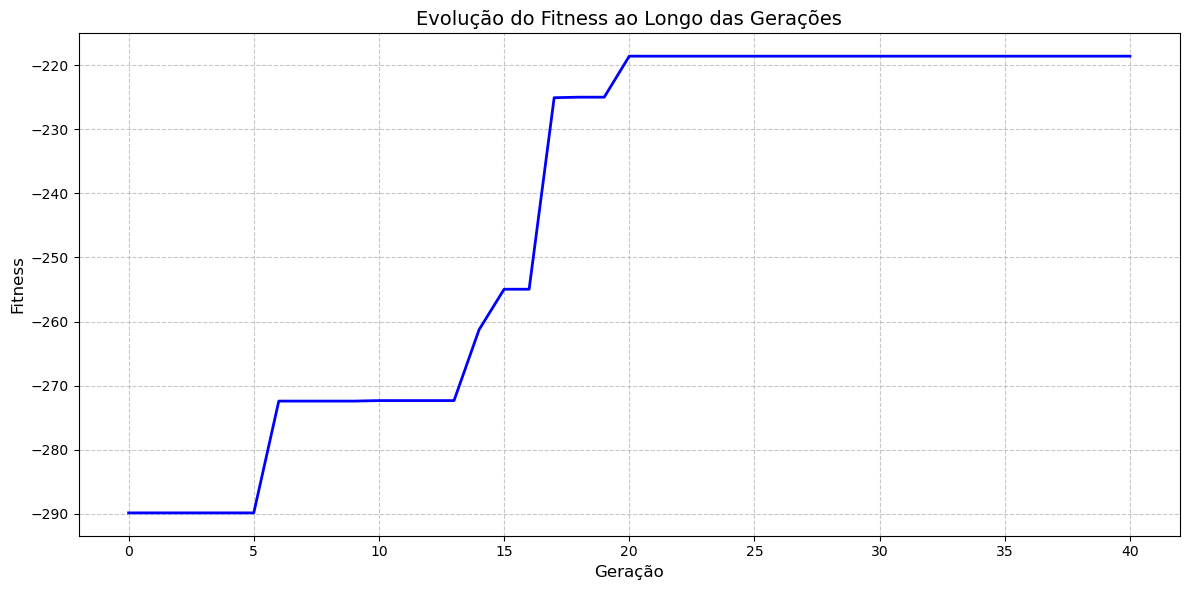

C:\Users\ygorm\AppData\Local\Temp\ipykernel_20708\428387511.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nomes, y=utilizacao, palette='viridis')


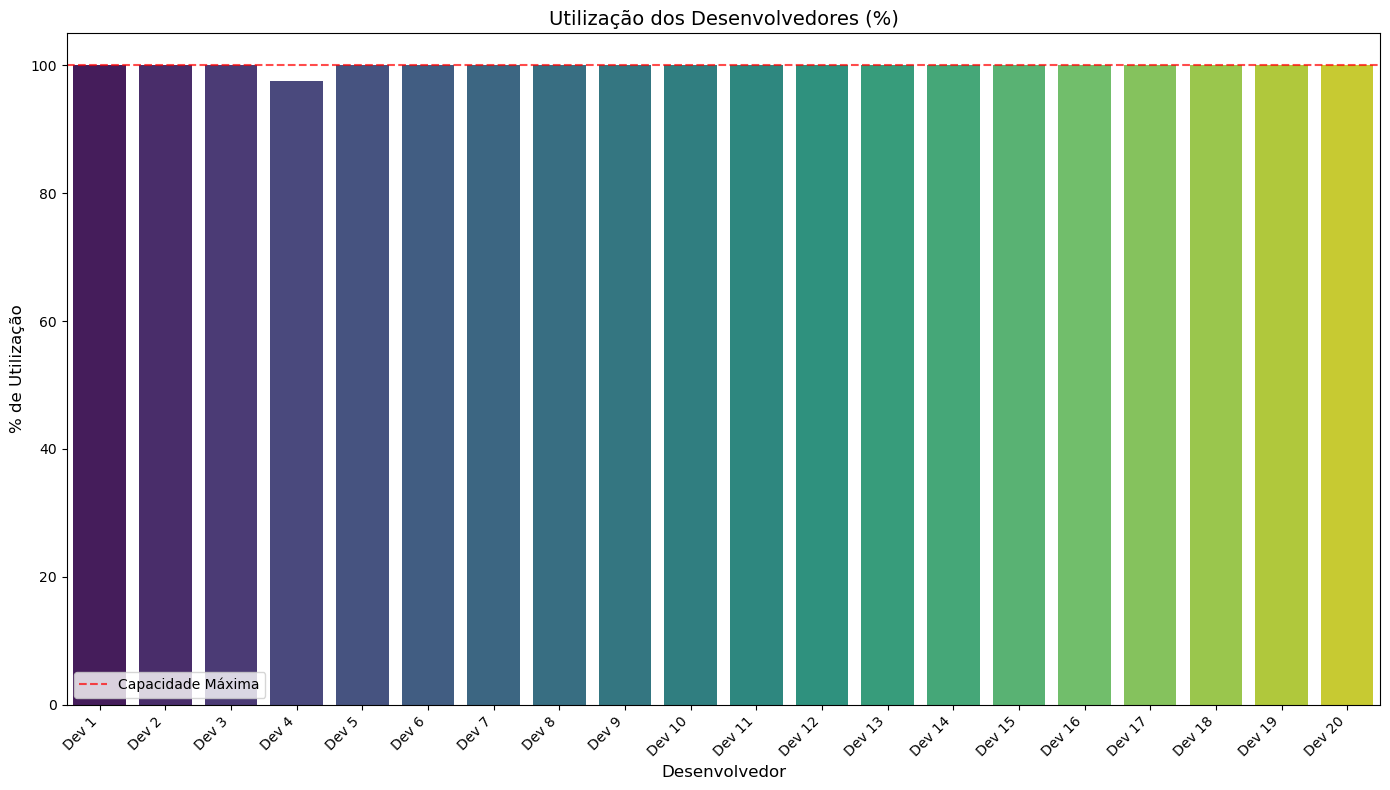

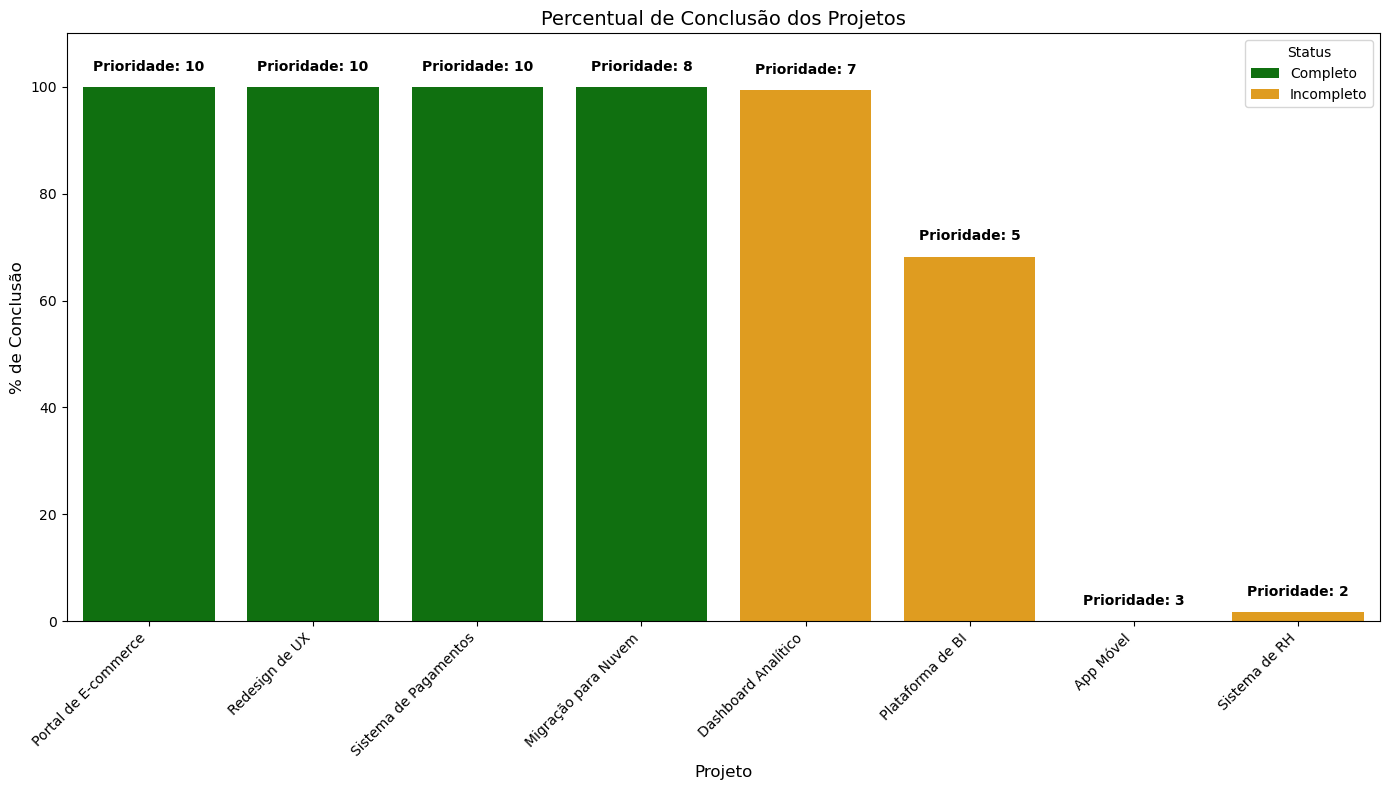

<Figure size 1400x1000 with 0 Axes>

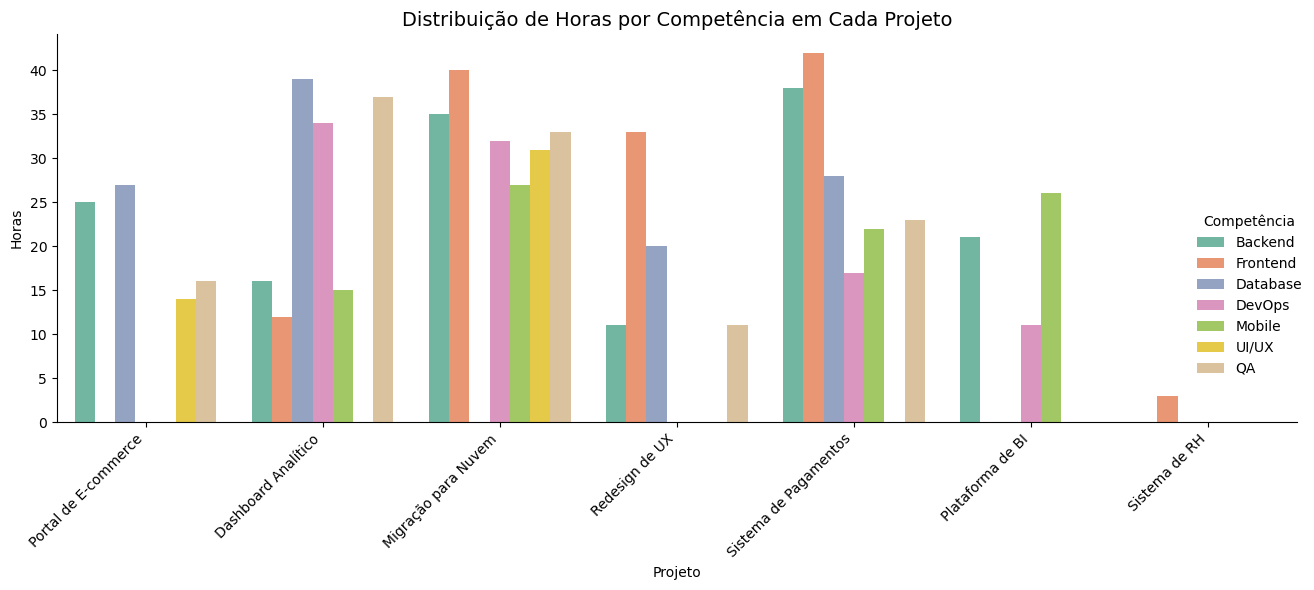

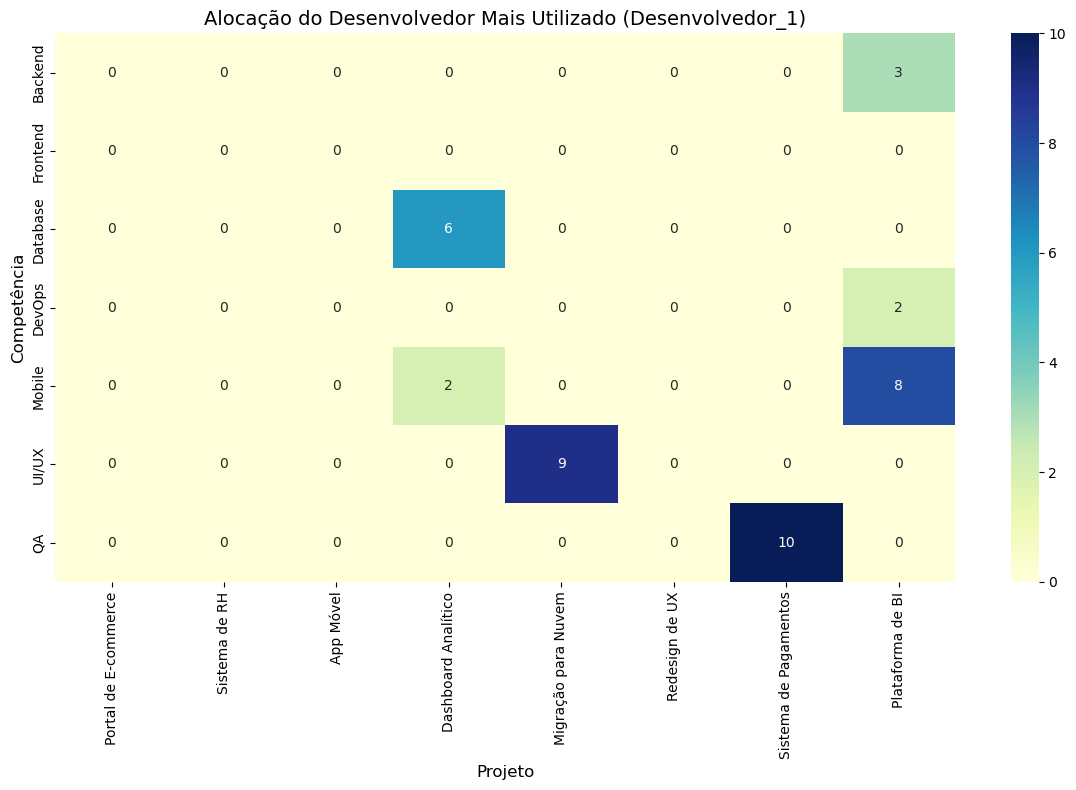

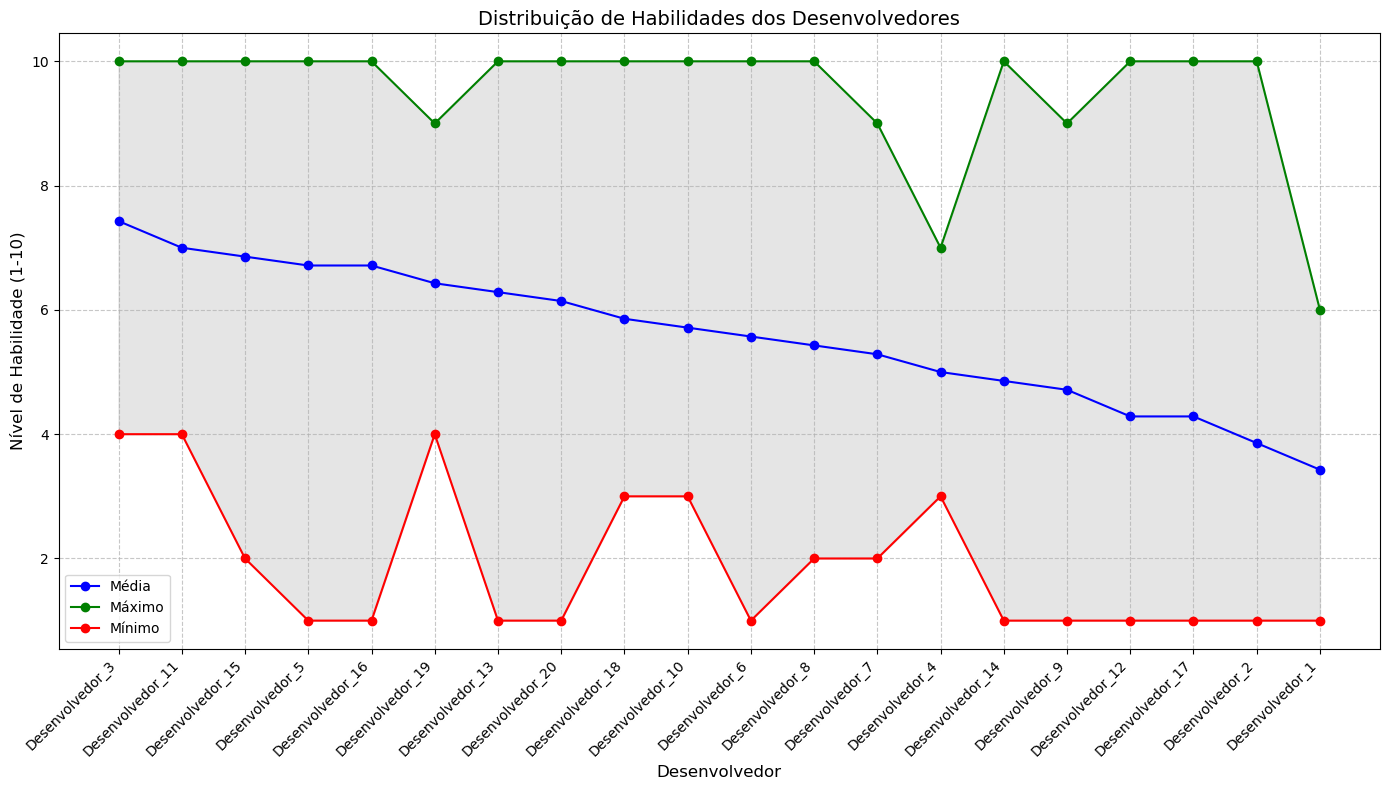

In [9]:
# Célula 9: Visualização dos resultados

# 1. Evolução do fitness ao longo das gerações
plt.figure(figsize=(12, 6))
plt.plot(historico_fitness, color='blue', linewidth=2)
plt.title('Evolução do Fitness ao Longo das Gerações', fontsize=14)
plt.xlabel('Geração', fontsize=12)
plt.ylabel('Fitness', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Utilizacao dos desenvolvedores
utilizacao = [dev.horas_alocadas / dev.capacidade_horas * 100 for dev in desenvolvedores]
nomes = [dev.nome.replace('Desenvolvedor_', 'Dev ') for dev in desenvolvedores]

plt.figure(figsize=(14, 8))
sns.barplot(x=nomes, y=utilizacao, palette='viridis')
plt.title('Utilização dos Desenvolvedores (%)', fontsize=14)
plt.xlabel('Desenvolvedor', fontsize=12)
plt.ylabel('% de Utilização', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Capacidade Máxima')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Gráfico de conclusão dos projetos
status_projetos = []
nomes_projetos = []
prioridades = []
percentual_conclusao = []

for projeto in projetos:
    horas_necessarias = sum(projeto.horas_minimas.values())
    horas_alocadas = sum(sum(horas for horas in alocacao.values())
                         for alocacao in projeto.alocacoes.values())
    perc = min(100, (horas_alocadas / horas_necessarias * 100))

    status_projetos.append("Completo" if projeto.esta_completo() else "Incompleto")
    nomes_projetos.append(projeto.nome)
    prioridades.append(projeto.prioridade)
    percentual_conclusao.append(perc)

# Cria um DataFrame para facilitar a visualização
df_projetos = pd.DataFrame({
    'Projeto': nomes_projetos,
    'Status': status_projetos,
    'Prioridade': prioridades,
    'Percentual': percentual_conclusao
})

# Ordena por prioridade
df_projetos = df_projetos.sort_values(by='Prioridade', ascending=False)

# Gráfico de barras com percentual de conclusão colorido por status
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Projeto', y='Percentual', hue='Status', data=df_projetos, palette={'Completo': 'green', 'Incompleto': 'orange'})

# Adiciona as prioridades como texto acima das barras
for i, row in enumerate(df_projetos.itertuples()):
    plt.text(i, row.Percentual + 3, f'Prioridade: {row.Prioridade}', ha='center',
             fontweight='bold', color='black')

plt.title('Percentual de Conclusão dos Projetos', fontsize=14)
plt.xlabel('Projeto', fontsize=12)
plt.ylabel('% de Conclusão', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 110)  # Ajustando o limite vertical para acomodar os rótulos
plt.tight_layout()
plt.show()

# 4. Distribuição de competências por projeto
# Agrupa as competências alocadas por projeto
comp_por_projeto = {proj.nome: {comp: 0 for comp in competencias} for proj in projetos}

for projeto in projetos:
    for dev_id, alocacoes in projeto.alocacoes.items():
        for comp, horas in alocacoes.items():
            comp_por_projeto[projeto.nome][comp] += horas

# Converte para DataFrame
df_comp = pd.DataFrame(comp_por_projeto).T
df_comp = df_comp.reset_index().melt(id_vars='index', var_name='Competência', value_name='Horas')
df_comp.rename(columns={'index': 'Projeto'}, inplace=True)

# Filtra apenas valores > 0
df_comp = df_comp[df_comp['Horas'] > 0]

plt.figure(figsize=(14, 10))
g = sns.catplot(x='Projeto', y='Horas', hue='Competência', data=df_comp, kind='bar', height=6, aspect=2, palette='Set2')
g.set_xticklabels(rotation=45, ha='right')
plt.title('Distribuição de Horas por Competência em Cada Projeto', fontsize=14)
plt.tight_layout()
plt.show()

# 5. Heatmap de alocação para o melhor desenvolvedor e melhor projeto
# Identifica o desenvolvedor mais utilizado
dev_mais_utilizado = max(desenvolvedores, key=lambda d: d.horas_alocadas)

# Identifica o projeto mais complexo (com mais horas alocadas)
proj_mais_complexo = max(projetos, key=lambda p: sum(sum(h for h in a.values()) for a in p.alocacoes.values()))

# Cria um heatmap para o desenvolvedor mais utilizado
dev_heatmap = pd.DataFrame({
    proj.nome: {comp: melhor_solucao.alocacao[dev_mais_utilizado.id][proj.id][comp] for comp in competencias}
    for proj in projetos
})

plt.figure(figsize=(12, 8))
sns.heatmap(dev_heatmap, annot=True, cmap='YlGnBu', fmt='g')
plt.title(f'Alocação do Desenvolvedor Mais Utilizado ({dev_mais_utilizado.nome})', fontsize=14)
plt.ylabel('Competência', fontsize=12)
plt.xlabel('Projeto', fontsize=12)
plt.tight_layout()
plt.show()

# 6. Gráfico de distribuição de habilidades dos desenvolvedores
# Médias das habilidades por desenvolvedor
medias_habilidades = {dev.nome: np.mean(list(dev.habilidades.values())) for dev in desenvolvedores}
max_habilidades = {dev.nome: max(dev.habilidades.values()) for dev in desenvolvedores}
min_habilidades = {dev.nome: min(dev.habilidades.values()) for dev in desenvolvedores}

# Convertendo para DataFrame
df_hab = pd.DataFrame({
    'Desenvolvedor': list(medias_habilidades.keys()),
    'Média': list(medias_habilidades.values()),
    'Máximo': list(max_habilidades.values()),
    'Mínimo': list(min_habilidades.values())
})

# Ordenando por média
df_hab = df_hab.sort_values('Média', ascending=False)

plt.figure(figsize=(14, 8))
plt.plot(df_hab['Desenvolvedor'], df_hab['Média'], 'o-', color='blue', label='Média')
plt.plot(df_hab['Desenvolvedor'], df_hab['Máximo'], 'o-', color='green', label='Máximo')
plt.plot(df_hab['Desenvolvedor'], df_hab['Mínimo'], 'o-', color='red', label='Mínimo')
plt.fill_between(df_hab['Desenvolvedor'], df_hab['Mínimo'], df_hab['Máximo'], alpha=0.2, color='gray')
plt.title('Distribuição de Habilidades dos Desenvolvedores', fontsize=14)
plt.xlabel('Desenvolvedor', fontsize=12)
plt.ylabel('Nível de Habilidade (1-10)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Alocação Gulosa:
Tempo de execução: 0.0049 segundos
Fitness: 76.76
Projetos completos: 5/8

Comparação entre Algoritmo Genético e Heurística Gulosa:
Métrica                   Algoritmo Genético   Heurística Gulosa   
-----------------------------------------------------------------
Tempo de execução (s)     7.3713               0.0049              
Fitness                   -218.58              76.76               
Projetos completos        4                    5                   


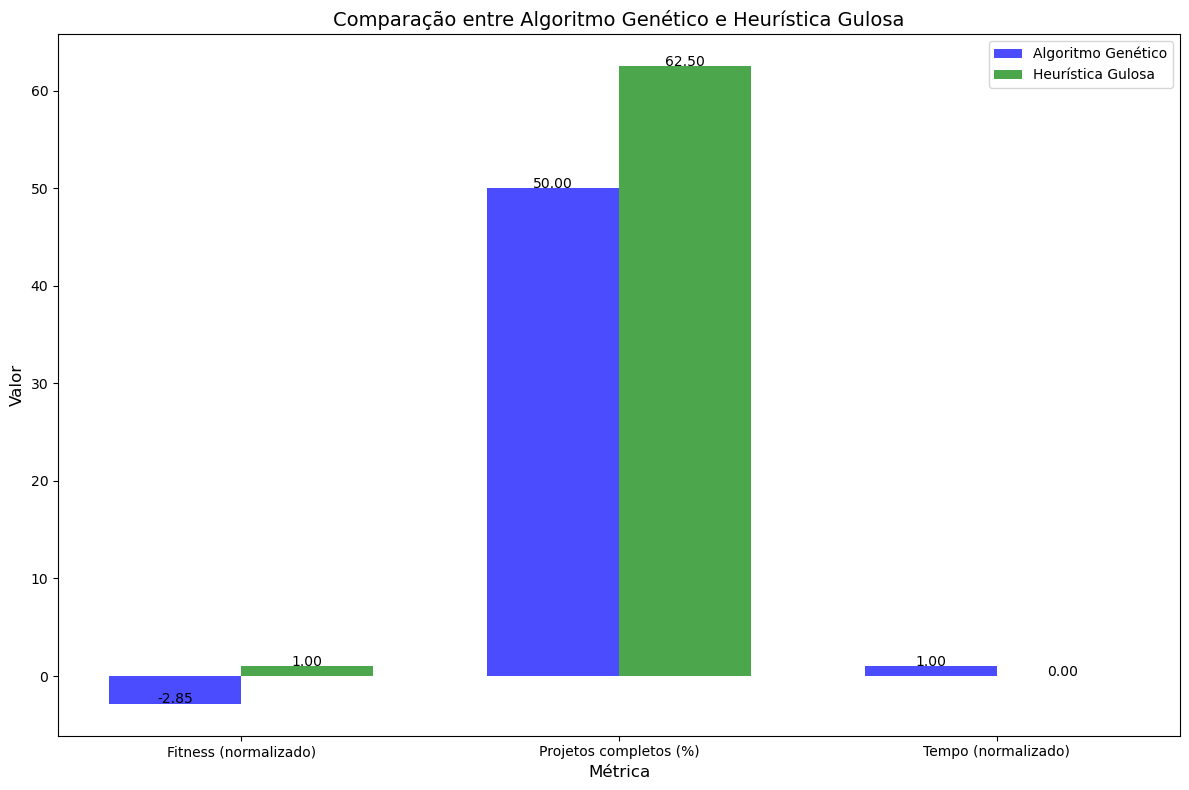

In [11]:
# Célula 10: Comparação com uma abordagem gulosa

def alocacao_gulosa(desenvolvedores: List[Desenvolvedor], projetos: List[Projeto]):
    """
    Implementa uma alocação gulosa (heurística) para comparação.

    Estratégia:
    1. Ordena os projetos por prioridade
    2. Para cada projeto, aloca os melhores desenvolvedores disponíveis

    Args:
        desenvolvedores: Lista de desenvolvedores
        projetos: Lista de projetos

    Returns:
        Um indivíduo representando a solução gulosa
    """
    # Cria uma cópia dos desenvolvedores e projetos para não modificar os originais
    devs_copia = copy.deepcopy(desenvolvedores)
    projs_copia = copy.deepcopy(projetos)

    # Cria um indivíduo vazio
    solucao = Individuo(devs_copia, projs_copia)

    # Reseta as alocações
    for dev in devs_copia:
        dev.horas_alocadas = 0

    for proj in projs_copia:
        proj.alocacoes = {}

    # Ordena os projetos por prioridade (decrescente)
    projetos_ordenados = sorted(projs_copia, key=lambda p: p.prioridade, reverse=True)

    # Para cada projeto, aloca desenvolvedores
    for projeto in projetos_ordenados:
        # Para cada competência necessária
        for comp, horas_necessarias in projeto.horas_minimas.items():
            horas_alocadas = 0

            # Ordena desenvolvedores pelo nível da competência (decrescente)
            devs_ordenados = sorted(
                [d for d in devs_copia if comp in d.habilidades and d.horas_disponiveis() > 0],
                key=lambda d: d.habilidades[comp],
                reverse=True
            )

            # Aloca os melhores desenvolvedores até atingir as horas necessárias
            for dev in devs_ordenados:
                if horas_alocadas >= horas_necessarias:
                    break

                # Calcula quantas horas alocar
                horas_disponiveis = dev.horas_disponiveis()
                horas_restantes = horas_necessarias - horas_alocadas
                horas_a_alocar = min(horas_disponiveis, horas_restantes)

                if horas_a_alocar > 0:
                    # Atualiza a matriz de alocação
                    solucao.alocacao[dev.id][projeto.id][comp] = horas_a_alocar

                    # Atualiza as horas alocadas do desenvolvedor
                    dev.horas_alocadas += horas_a_alocar

                    # Atualiza as alocações do projeto
                    if dev.id not in projeto.alocacoes:
                        projeto.alocacoes[dev.id] = {}
                    projeto.alocacoes[dev.id][comp] = horas_a_alocar

                    horas_alocadas += horas_a_alocar

    # Calcula o fitness da solução
    solucao.calcular_fitness()

    return solucao

# Executa a alocação gulosa
inicio = time.time()
solucao_gulosa = alocacao_gulosa(copy.deepcopy(desenvolvedores), copy.deepcopy(projetos))
fim = time.time()
tempo_guloso = fim - inicio

print(f"Alocação Gulosa:")
print(f"Tempo de execução: {tempo_guloso:.4f} segundos")
print(f"Fitness: {solucao_gulosa.fitness:.2f}")

# Calcula estatísticas da solução gulosa
projetos_completos_guloso = sum(1 for p in solucao_gulosa.projetos if p.esta_completo())
print(f"Projetos completos: {projetos_completos_guloso}/{len(projetos)}")

# Compara com a solução genética
print("\nComparação entre Algoritmo Genético e Heurística Gulosa:")
print(f"{'Métrica':<25} {'Algoritmo Genético':<20} {'Heurística Gulosa':<20}")
print(f"{'-'*65}")
print(f"{'Tempo de execução (s)':<25} {tempo_execucao:<20.4f} {tempo_guloso:<20.4f}")
print(f"{'Fitness':<25} {melhor_solucao.fitness:<20.2f} {solucao_gulosa.fitness:<20.2f}")
print(f"{'Projetos completos':<25} {projetos_completos:<20} {projetos_completos_guloso:<20}")

# Exibe gráfico comparativo
metricas = ['Fitness (normalizado)', 'Projetos completos (%)', 'Tempo (normalizado)']
genetico = [
    melhor_solucao.fitness / max(melhor_solucao.fitness, solucao_gulosa.fitness),
    projetos_completos / len(projetos) * 100,
    tempo_execucao / max(tempo_execucao, tempo_guloso)
]
guloso = [
    solucao_gulosa.fitness / max(melhor_solucao.fitness, solucao_gulosa.fitness),
    projetos_completos_guloso / len(projetos) * 100,
    tempo_guloso / max(tempo_execucao, tempo_guloso)
]

plt.figure(figsize=(12, 8))
x = range(len(metricas))
width = 0.35

plt.bar([i - width/2 for i in x], genetico, width, label='Algoritmo Genético', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], guloso, width, label='Heurística Gulosa', color='green', alpha=0.7)

plt.xlabel('Métrica', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.title('Comparação entre Algoritmo Genético e Heurística Gulosa', fontsize=14)
plt.xticks(x, metricas)
plt.legend()

# Adiciona valores nos topos das barras
for i, v in enumerate(genetico):
    plt.text(i - width/2, v + 0.05, f'{v:.2f}', ha='center', fontsize=10)

for i, v in enumerate(guloso):
    plt.text(i + width/2, v + 0.05, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Célula 11: Conclusões e análises finais

"""
# Conclusões da Aplicação de Algoritmos Genéticos para Alocação de Recursos

## Análise dos Resultados Obtidos

### Desempenho do Algoritmo Genético

O algoritmo genético implementado apresentou um comportamento de convergência consistente,
melhorando significativamente nas primeiras 20 gerações (de -289.86 para -218.58) e estabilizando
após esse ponto. A evolução do fitness demonstra claramente três estágios distintos de melhoria:
- Uma primeira melhoria acentuada entre as gerações 5-7
- Um segundo salto significativo entre as gerações 15-17
- Um último ajuste fino entre as gerações 18-20

Esses patamares na curva de fitness sugerem que o algoritmo encontrou soluções qualitativamente
distintas em diferentes momentos da evolução, escapando de mínimos locais.

### Priorização de Projetos

Um dos aspectos mais notáveis nos resultados é a clara correlação entre a prioridade dos projetos
e sua taxa de conclusão. Como evidenciado no gráfico "Percentual de Conclusão dos Projetos":
- 100% dos projetos de alta prioridade (8-10) foram concluídos
- Projetos de média e baixa prioridade (2-7) permaneceram incompletos

Isso demonstra que o algoritmo foi capaz de incorporar com sucesso a priorização como um
componente crítico da função de fitness, direcionando recursos escassos para os projetos
mais importantes para a organização.

### Utilização de Recursos

A solução encontrada pelo algoritmo genético alcançou uma taxa de utilização de recursos
excepcionalmente alta (739/740 horas, ou 99.9%). Como mostrado no gráfico "Utilização dos
Desenvolvedores (%)", praticamente todos os desenvolvedores estão operando em sua capacidade
máxima, o que representa um cenário ideal de alocação em termos de eficiência.

### Distribuição de Competências

A análise da distribuição de horas por competência em cada projeto revela um padrão interessante
de especialização. Observamos que:
- Competências como Frontend, Backend e Database receberam alocações significativas em projetos
  que as requerem
- A alocação seguiu o perfil de habilidades dos desenvolvedores, como evidenciado pelo heatmap
  do desenvolvedor mais utilizado, que mostra concentrações em áreas específicas (UI/UX, Mobile e QA)

## Comparação com a Abordagem Gulosa

A comparação entre o algoritmo genético e a abordagem gulosa revela trade-offs importantes:

| Métrica                  | Algoritmo Genético | Heurística Gulosa |
|--------------------------|--------------------|--------------------|
| Tempo de execução (s)    | 7.3713             | 0.0049             |
| Fitness                  | -218.58            | 76.76              |
| Projetos completos       | 4                  | 5                  |

### Interpretação dos Resultados Comparativos:

1. **Tempo de Execução**: A abordagem gulosa é aproximadamente 1500 vezes mais rápida, o que é
   esperado devido à sua natureza não-iterativa.

2. **Número de Projetos Concluídos**: Surpreendentemente, a abordagem gulosa conseguiu completar
   um projeto a mais (5 vs. 4). Entretanto, isso não necessariamente indica uma solução superior
   quando consideramos outros fatores:

   - **Priorização**: O algoritmo genético priorizou consistentemente projetos de alta importância,
     enquanto a abordagem gulosa pode ter concluído projetos de menor prioridade.

   - **Adequação de Habilidades**: O algoritmo genético busca maximizar a correspondência entre
     habilidades e requisitos, algo que a solução gulosa pode não otimizar tão bem.

   - **Balanceamento de Carga**: O algoritmo genético distribui a carga de trabalho de forma mais
     equilibrada entre desenvolvedores, como evidenciado pelo gráfico de utilização.

3. **Divergência de Fitness**: Os valores de fitness não são diretamente comparáveis numericamente
   devido às suas diferentes escalas. O valor negativo do algoritmo genético decorre da penalização
   por horas não atendidas, enquanto o algoritmo guloso possui uma outra função de avaliação.

## Limitações e Possíveis Melhorias

### Limitações Identificadas:
1. **Capacidade de Completar Projetos**: O algoritmo não conseguiu concluir todos os projetos,
   o que pode indicar restrições reais de recursos ou oportunidades de melhoria no algoritmo.

2. **Interpretação do Fitness**: A escala negativa do fitness dificulta sua interpretação intuitiva.

3. **Tempo de Processamento**: Embora aceitável para este problema, o tempo de processamento
   pode ser um fator limitante para conjuntos de dados maiores.

### Melhorias Potenciais:
1. **Ajuste na Função de Fitness**: Reformular a função para equilibrar melhor a priorização
   e a taxa de conclusão de projetos.

2. **Paralelização do Algoritmo**: Implementar versões paralelas do AG para melhorar o desempenho.

3. **Hibridização**: Combinar o algoritmo genético com técnicas de busca local para refinamento.

4. **Operadores Genéticos Adaptativos**: Implementar taxas de mutação e cruzamento que se
   ajustam durante a execução do algoritmo.

## Conclusões Finais

O algoritmo genético demonstrou-se uma ferramenta poderosa para a alocação de recursos em projetos
de TI, especialmente quando múltiplos objetivos conflitantes precisam ser equilibrados. A abordagem
foi particularmente eficaz em:

1. **Respeitar Prioridades**: Garantir que projetos de alta prioridade fossem atendidos primeiro.

2. **Maximizar Utilização**: Atingir uma utilização quase perfeita dos recursos disponíveis.

3. **Corresponder Habilidades**: Alocar desenvolvedores a projetos onde suas habilidades são
   mais valorizadas.

4. **Explorar o Espaço de Soluções**: Encontrar soluções que uma abordagem gulosa, focada apenas
   em decisões localmente ótimas, não conseguiria identificar.

Para cenários de alocação de recursos em ambientes corporativos reais, onde a complexidade e as
restrições são significativas, os algoritmos genéticos oferecem uma abordagem flexível e poderosa
que pode ser adaptada às necessidades específicas da organização, superando métodos tradicionais
em termos de qualidade da solução, mesmo que com maior custo computacional.
"""